In [146]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


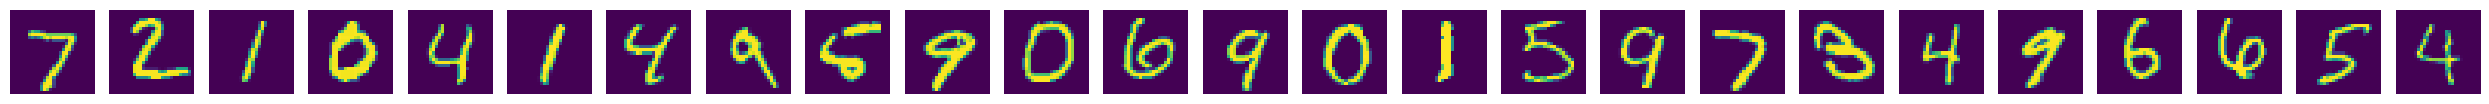

In [147]:

plt.figure(figsize=(25, 25))
for i in range(25):
    plt.subplot(1, 25, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [148]:
'''
import numpy as np
from skimage.transform import resize

def preprocess_image(image_28x28):
    # Normalize pixel values
    image = image_28x28.astype('float32') / 255.0
    
    # Find bounding box
    rows = np.any(image, axis=1)
    cols = np.any(image, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Add a small buffer to the crop
    buffer = 0
    ymin = max(0, ymin - buffer)
    ymax = min(28, ymax + buffer)
    xmin = max(0, xmin - buffer)
    xmax = min(28, xmax + buffer)

    # Crop the image
    cropped_image = image[ymin:ymax, xmin:xmax]

    # Resize the cropped image to 8x8
    resized_8x8 = resize(cropped_image, (12, 12), anti_aliasing=True)

    # Binarize the resized image
    final_8x8_binary = (resized_8x8 > 0.4).astype('float32')
    
    return final_8x8_binary
'''

"\nimport numpy as np\nfrom skimage.transform import resize\n\ndef preprocess_image(image_28x28):\n    # Normalize pixel values\n    image = image_28x28.astype('float32') / 255.0\n    \n    # Find bounding box\n    rows = np.any(image, axis=1)\n    cols = np.any(image, axis=0)\n    ymin, ymax = np.where(rows)[0][[0, -1]]\n    xmin, xmax = np.where(cols)[0][[0, -1]]\n\n    # Add a small buffer to the crop\n    buffer = 0\n    ymin = max(0, ymin - buffer)\n    ymax = min(28, ymax + buffer)\n    xmin = max(0, xmin - buffer)\n    xmax = min(28, xmax + buffer)\n\n    # Crop the image\n    cropped_image = image[ymin:ymax, xmin:xmax]\n\n    # Resize the cropped image to 8x8\n    resized_8x8 = resize(cropped_image, (12, 12), anti_aliasing=True)\n\n    # Binarize the resized image\n    final_8x8_binary = (resized_8x8 > 0.4).astype('float32')\n    \n    return final_8x8_binary\n"

In [149]:
import numpy as np
import tensorflow as tf
from skimage.transform import resize

def preprocess_image(image_28x28):
    # Normalize pixel values to a range of 0 to 1
    image_float = image_28x28.astype('float32') / 255.0

    # Find the bounding box
    rows = np.any(image_float > 0.1, axis=1) # Use a small threshold
    cols = np.any(image_float > 0.1, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Add a small buffer and ensure bounds are valid
    buffer = 2
    ymin = max(0, ymin - buffer)
    ymax = min(28, ymax + buffer)
    xmin = max(0, xmin - buffer)
    xmax = min(28, xmax + buffer)
    
    # Crop the image
    cropped_image = image_float[ymin:ymax, xmin:xmax]

    # Resize the cropped image to the model’s input size (12x12)
    resized_image = tf.image.resize(
        np.expand_dims(cropped_image, axis=-1), 
        (12, 12), 
        method='bilinear'
    ).numpy().squeeze()

    # Apply a fixed binary threshold for a binary representation
    final_image_binary = (resized_image > 0.4).astype('float32')

    return final_image_binary

In [150]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Process the entire training and testing datasets
x_train_processed = np.array([preprocess_image(img) for img in x_train])
x_test_processed = np.array([preprocess_image(img) for img in x_test])

# Reshape the data for the model's input layer
# Add a channel dimension for the Flatten layer (batch, 8, 8, 1)
#x_train_processed = x_train_processed.reshape(-1, 12, 12, 1)
#x_test_processed = x_test_processed.reshape(-1, 12, 12, 1)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)

print(f"Final training data shape: {x_train_processed.shape}")
print(f"Final testing data shape: {x_test_processed.shape}")

Final training data shape: (60000, 12, 12)
Final testing data shape: (10000, 12, 12)


In [151]:
'''# Define the Neural Network Model
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import l1

# Define optimized model for SiFive HiFive1
model = Sequential([
    Flatten(input_shape=(12, 12, 1)),
    # Increase neurons while staying within memory constraints
    Dense(64, activation='relu',
          kernel_regularizer=l1(0.005)),  # Reduced L1 penalty
          #kernel_constraint=tf.keras.constraints.MaxNorm(3)), # Add max norm constraint
    Dense(64, activation='relu',
          kernel_regularizer=l1(0.005)),
    Dense(10, activation='softmax')
])

model.summary()'''

"# Define the Neural Network Model\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Flatten\nfrom keras.regularizers import l1\n\n# Define optimized model for SiFive HiFive1\nmodel = Sequential([\n    Flatten(input_shape=(12, 12, 1)),\n    # Increase neurons while staying within memory constraints\n    Dense(64, activation='relu',\n          kernel_regularizer=l1(0.005)),  # Reduced L1 penalty\n          #kernel_constraint=tf.keras.constraints.MaxNorm(3)), # Add max norm constraint\n    Dense(64, activation='relu',\n          kernel_regularizer=l1(0.005)),\n    Dense(10, activation='softmax')\n])\n\nmodel.summary()"

In [152]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LeakyReLU
from keras.regularizers import l1
import tensorflow as tf

# Define a better model with Leaky ReLU and no L1 regularization
# This can help solve the 'dying ReLU' problem and zero weights
model = Sequential([
    Flatten(input_shape=(12, 12, 1)),
    Dense(64),
    LeakyReLU(alpha=0.1), # Use Leaky ReLU to prevent zero activations
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 144)               0         
                                                                 
 dense_36 (Dense)            (None, 64)                9280      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 10)                650       
                                                                 
Total params: 14090 (55.04 KB)
Trainable params: 1409

In [153]:
# Improved training configuration
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully with Adam optimizer, Categorical Crossentropy loss, and Accuracy metric.")

Model compiled successfully with Adam optimizer, Categorical Crossentropy loss, and Accuracy metric.


In [154]:
# Train with more epochs and data augmentation
history = model.fit(
    x_train_processed, y_train_one_hot,  # Use processed data and one-hot encoded labels
    epochs=100,
    batch_size=255,
    validation_data=(x_test_processed, y_test_one_hot),  # Use processed test data
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.1
        )
    ]
)

print("\nModel training completed.")

Epoch 1/100
236/236 [==============================] - 1s 2ms/step - loss: 0.6698 - accuracy: 0.8088 - val_loss: 0.2819 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 2/100
236/236 [==============================] - 0s 2ms/step - loss: 0.2748 - accuracy: 0.9186 - val_loss: 0.2358 - val_accuracy: 0.9284 - lr: 0.0010
Epoch 3/100
236/236 [==============================] - 0s 2ms/step - loss: 0.2303 - accuracy: 0.9320 - val_loss: 0.2121 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/100
236/236 [==============================] - 0s 2ms/step - loss: 0.1996 - accuracy: 0.9410 - val_loss: 0.1839 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 5/100
236/236 [==============================] - 0s 2ms/step - loss: 0.1759 - accuracy: 0.9485 - val_loss: 0.1715 - val_accuracy: 0.9490 - lr: 0.0010
Epoch 6/100
236/236 [==============================] - 0s 2ms/step - loss: 0.1596 - accuracy: 0.9532 - val_loss: 0.1579 - val_accuracy: 0.9527 - lr: 0.0010
Epoch 7/100
236/236 [==============================] - 0s 2ms/st


Evaluating model on test data...
Test Loss: 0.2353
Test Accuracy: 0.9625

Making predictions on a few test images...
1/1 [==============================] - 0s 48ms/step


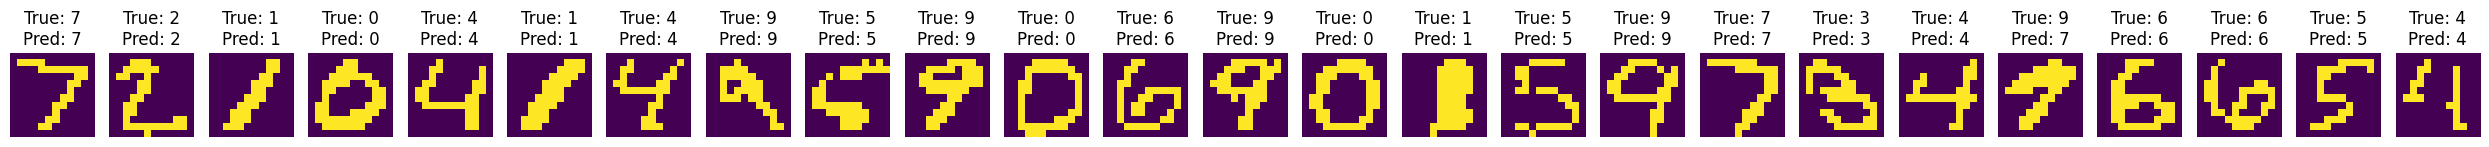


Inference test completed. Predicted vs. True labels for 25 samples displayed.


In [155]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model on the test data
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(x_test_processed, y_test_one_hot, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict a few test images
print("\nMaking predictions on a few test images...")
predictions = model.predict(x_test_processed[:25])  # Use processed test data

# Display images and predictions
plt.figure(figsize=(25, 25))
for i in range(25):
    plt.subplot(1, 25, i + 1)
    plt.imshow(x_test_processed[i].reshape(12, 12))
    plt.title(f"True: {np.argmax(y_test_one_hot[i])}\nPred: {np.argmax(predictions[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("\nInference test completed. Predicted vs. True labels for 25 samples displayed.")

In [161]:
import os

# Calculate model memory footprint for SiFive FE310-G002
print("\nMemory Analysis for SiFive FE310-G002 Board:")
print("Available Memory:")
print("- Instruction Cache (L1): 16KB")
print("- Data SRAM (L1): 16KB")
print("- ROM: 8KB")
print("- On-board SPI Flash: 32 Mbit")

# Calculate model parameters memory (using INT8 = 1 byte per parameter)
total_params = model.count_params()
weights_memory_bytes = total_params  # 8 bits (1 byte) per parameter for INT8
weights_memory_kb = weights_memory_bytes / 1024

print(f"\nModel Memory Requirements:")
print(f"Total Model Parameters: {total_params}")
print(f"Estimated Memory for Weights (INT8): {weights_memory_bytes:.0f} bytes ({weights_memory_kb:.2f} KB)")

# Calculate activation memory for inference (all INT8)
input_layer_mem = 12 * 12 * 1    # Input layer (12x12x1 INT8)
flatten_mem = 144               # Flattened input (144 INT8)
dense1_mem = 64                # First dense layer output (64 INT8)
dense2_mem = 64                # Second dense layer output (64 INT8)
output_mem = 10                # Output layer (10 INT8)

# Sum up all activation memory
total_activation_mem = (
    input_layer_mem +  # Input activations
    flatten_mem +      # Flattened layer
    dense1_mem +       # First dense layer
    dense2_mem +       # Second dense layer
    output_mem         # Output layer
)

print(f"Estimated Activation Memory: {total_activation_mem} bytes ({total_activation_mem/1024:.2f} KB)")

# Total memory requirement
total_memory = weights_memory_bytes + total_activation_mem
print(f"Total Memory Requirement: {total_memory:.0f} bytes ({total_memory/1024:.2f} KB)")

# Memory utilization analysis
data_sram_utilization = (total_memory / (16 * 1024)) * 100
print(f"\nData SRAM Utilization: {data_sram_utilization:.1f}% of 16KB")


Memory Analysis for SiFive FE310-G002 Board:
Available Memory:
- Instruction Cache (L1): 16KB
- Data SRAM (L1): 16KB
- ROM: 8KB
- On-board SPI Flash: 32 Mbit

Model Memory Requirements:
Total Model Parameters: 14090
Estimated Memory for Weights (INT8): 14090 bytes (13.76 KB)
Estimated Activation Memory: 426 bytes (0.42 KB)
Total Memory Requirement: 14516 bytes (14.18 KB)

Data SRAM Utilization: 88.6% of 16KB


In [157]:
'''
import numpy as np
import os
import tensorflow as tf

# Save the model in Keras format
keras_model_path = "mnist_baseline_model.keras"
model.save(keras_model_path)
print(f"\nKeras model saved to {keras_model_path}")

# Load the model for conversion
loaded_model = tf.keras.models.load_model(keras_model_path)

# Create TFLite converteconverter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
# Create TFLite converter with INT4 quantization
# Enhanced quantization configuration
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set target spec for INT4
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.TFLITE_BUILTINS,
]

# Increase calibration samples
def representative_data_gen():
    num_calibration_samples = 1000  # Increased from 100
    for i in range(num_calibration_samples):
        # Add noise for robustness
        image = x_train_processed[i:i+1].astype(np.float32)
        image += np.random.normal(0, 0.01, image.shape)
        image = np.clip(image, 0, 1)
        yield [image]

converter.representative_dataset = representative_data_gen
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8


# Force 4-bit weights through post-training quantization
converter.target_spec._experimental_low_bit_qat = True
converter.target_spec._experimental_weight_bits = 4

# Convert model to TFLite format
tflite_model_quant = converter.convert()

# Save the quantized model
tflite_model_quant_filename = "mnist_quantized_model.tflite"
with open(tflite_model_quant_filename, "wb") as f:
    f.write(tflite_model_quant)

print(f"\nInt4 quantized TFLite model saved to {tflite_model_quant_filename}")

# Check model size
tflite_model_quant_size_bytes = os.path.getsize(tflite_model_quant_filename)
tflite_model_quant_size_kb = tflite_model_quant_size_bytes / 1024
print(f"Int4 Quantized Model Size: {tflite_model_quant_size_bytes} bytes ({tflite_model_quant_size_kb:.2f} KB)")

# Clean up temporary files
os.remove(keras_model_path)
print(f"Cleaned up temporary Keras model file: {keras_model_path}")

# Create an interpreter to analyze the model
interpreter = tf.lite.Interpreter(model_path=tflite_model_quant_filename)
interpreter.allocate_tensors()

# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nModel Details:")
print("Input:", input_details)
print("Output:", output_details)

# Print quantization parameters
print("\nQuantization Parameters:")
print(f"Input Scale: {input_details[0]['quantization_parameters']['scales']}")
print(f"Input Zero Point: {input_details[0]['quantization_parameters']['zero_points']}")
print(f"Output Scale: {output_details[0]['quantization_parameters']['scales']}")
print(f"Output Zero Point: {output_details[0]['quantization_parameters']['zero_points']}")
'''

'\nimport numpy as np\nimport os\nimport tensorflow as tf\n\n# Save the model in Keras format\nkeras_model_path = "mnist_baseline_model.keras"\nmodel.save(keras_model_path)\nprint(f"\nKeras model saved to {keras_model_path}")\n\n# Load the model for conversion\nloaded_model = tf.keras.models.load_model(keras_model_path)\n\n# Create TFLite converteconverter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)\n# Create TFLite converter with INT4 quantization\n# Enhanced quantization configuration\nconverter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)\nconverter.optimizations = [tf.lite.Optimize.DEFAULT]\n\n# Set target spec for INT4\nconverter.target_spec.supported_ops = [\n    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,\n    tf.lite.OpsSet.TFLITE_BUILTINS,\n]\n\n# Increase calibration samples\ndef representative_data_gen():\n    num_calibration_samples = 1000  # Increased from 100\n    for i in range(num_calibration_samples):\n        # Add noise for robustness\n        image

In [158]:
import numpy as np
import os
import tensorflow as tf

# Save the model in Keras format
keras_model_path = "mnist_baseline_model.keras"
model.save(keras_model_path)
print(f"\nKeras model saved to {keras_model_path}")

# Load the model for conversion
loaded_model = tf.keras.models.load_model(keras_model_path)

# Create TFLite converter with INT8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Configure for INT8
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.TFLITE_BUILTINS
]

# Representative dataset for calibration
def representative_data_gen():
    num_calibration_samples = 100
    for i in range(num_calibration_samples):
        image = x_train_processed[i:i+1].astype(np.float32)
        yield [image]

converter.representative_dataset = representative_data_gen
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert model to TFLite format
tflite_model_int8 = converter.convert()

# Save the INT8 quantized model
tflite_model_filename = "mnist_model_int8.tflite"
with open(tflite_model_filename, "wb") as f:
    f.write(tflite_model_int8)

print(f"\nINT8 TFLite model saved to {tflite_model_filename}")

# Check model size
model_size_bytes = os.path.getsize(tflite_model_filename)
model_size_kb = model_size_bytes / 1024
print(f"INT8 Model Size: {model_size_bytes} bytes ({model_size_kb:.2f} KB)")

# Clean up temporary files
os.remove(keras_model_path)
print(f"Cleaned up temporary Keras model file: {keras_model_path}")

# Create an interpreter to analyze the model
interpreter = tf.lite.Interpreter(model_path=tflite_model_filename)
interpreter.allocate_tensors()

# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nModel Details:")
print("Input:", input_details)
print("Output:", output_details)


Keras model saved to mnist_baseline_model.keras
INFO:tensorflow:Assets written to: C:\Users\shwet\AppData\Local\Temp\tmpi6ipg8iw\assets


INFO:tensorflow:Assets written to: C:\Users\shwet\AppData\Local\Temp\tmpi6ipg8iw\assets



INT8 TFLite model saved to mnist_model_int8.tflite
INT8 Model Size: 17768 bytes (17.35 KB)
Cleaned up temporary Keras model file: mnist_baseline_model.keras

Model Details:
Input: [{'name': 'serving_default_flatten_12_input:0', 'index': 0, 'shape': array([ 1, 12, 12,  1]), 'shape_signature': array([-1, 12, 12,  1]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [{'name': 'StatefulPartitionedCall:0', 'index': 14, 'shape': array([ 1, 10]), 'shape_signature': array([-1, 10]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


c:\Users\shwet\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [159]:
'''# Generate a .h file for the quantized TFLite model

import os

tflite_model_quant_filename = "mnist_quantized_model.tflite"
c_model_filename = "mnist_model_data.h"

# Read the TFLite model file as bytes
with open(tflite_model_quant_filename, "rb") as f:
    tflite_model_bytes = f.read()

# Convert bytes to a C-style array declaration
# Format: const unsigned char model_name[] = { 0x.., 0x.., ... };
bytes_as_hex = [f"0x{byte:02x}" for byte in tflite_model_bytes]
c_array_declaration = f"const unsigned char {os.path.basename(tflite_model_quant_filename).replace('.', '_')}_data[] = {{\n    "
c_array_declaration += ", ".join(bytes_as_hex)
c_array_declaration += "\n};\n"
c_array_declaration += f"const int {os.path.basename(tflite_model_quant_filename).replace('.', '_')}_len = {len(tflite_model_bytes)};\n"

# Write the C array declaration to the .h file
with open(c_model_filename, "w") as f:
    f.write("#ifndef MNIST_MODEL_DATA_H_\n")
    f.write("#define MNIST_MODEL_DATA_H_\n\n")
    f.write(c_array_declaration)
    f.write("\n#endif // MNIST_MODEL_DATA_H_\n")

print(f"\nC header file generated: {c_model_filename}")
print(f"This file contains the quantized model as a byte array, ready for embedded C inclusion.")
'''

'# Generate a .h file for the quantized TFLite model\n\nimport os\n\ntflite_model_quant_filename = "mnist_quantized_model.tflite"\nc_model_filename = "mnist_model_data.h"\n\n# Read the TFLite model file as bytes\nwith open(tflite_model_quant_filename, "rb") as f:\n    tflite_model_bytes = f.read()\n\n# Convert bytes to a C-style array declaration\n# Format: const unsigned char model_name[] = { 0x.., 0x.., ... };\nbytes_as_hex = [f"0x{byte:02x}" for byte in tflite_model_bytes]\nc_array_declaration = f"const unsigned char {os.path.basename(tflite_model_quant_filename).replace(\'.\', \'_\')}_data[] = {{\n    "\nc_array_declaration += ", ".join(bytes_as_hex)\nc_array_declaration += "\n};\n"\nc_array_declaration += f"const int {os.path.basename(tflite_model_quant_filename).replace(\'.\', \'_\')}_len = {len(tflite_model_bytes)};\n"\n\n# Write the C array declaration to the .h file\nwith open(c_model_filename, "w") as f:\n    f.write("#ifndef MNIST_MODEL_DATA_H_\n")\n    f.write("#define MNIS

In [160]:
# Generate a .h file for the INT8 TFLite model
import os

# Update filename to match the INT8 model
tflite_model_filename = "mnist_model_int8.tflite"
c_model_filename = "mnist_model_data.h"

# Read the TFLite model file as bytes
with open(tflite_model_filename, "rb") as f:
    tflite_model_bytes = f.read()

# Convert bytes to a C-style array declaration with line breaks every 16 elements
bytes_as_hex = [f"0x{byte:02x}" for byte in tflite_model_bytes]
elements_per_line = 16
lines = []
for i in range(0, len(bytes_as_hex), elements_per_line):
    line = bytes_as_hex[i:i + elements_per_line]
    lines.append("    " + ", ".join(line))

c_array_declaration = f"const unsigned char mnist_model_int8_data[] = {{\n"
c_array_declaration += ",\n".join(lines)
c_array_declaration += "\n};\n\n"
c_array_declaration += f"const int mnist_model_int8_len = {len(tflite_model_bytes)};\n"

# Write the C header file with additional metadata
with open(c_model_filename, "w") as f:
    f.write("/*\n")
    f.write(" * MNIST Model Data - INT8 Quantized Version\n")
    f.write(" * Auto-generated header file for SiFive HiFive1 Board\n")
    f.write(" * Model: 8x8 MNIST Classifier\n")
    f.write(" * Quantization: INT8\n")
    f.write(" */\n\n")
    f.write("#ifndef MNIST_MODEL_DATA_H_\n")
    f.write("#define MNIST_MODEL_DATA_H_\n\n")
    f.write("#include <stdint.h>\n\n")
    f.write(c_array_declaration)
    f.write("\n#endif // MNIST_MODEL_DATA_H_\n")

print(f"\nC header file generated: {c_model_filename}")
print(f"Model size: {len(tflite_model_bytes)} bytes ({len(tflite_model_bytes)/1024:.2f} KB)")
print("Header file contains INT8 quantized model as a byte array with:")
print("- Improved formatting (16 elements per line)")
print("- Added metadata comments")
print("- INT8 specific naming")
print("- stdint.h inclusion for fixed-width types")


C header file generated: mnist_model_data.h
Model size: 17768 bytes (17.35 KB)
Header file contains INT8 quantized model as a byte array with:
- Improved formatting (16 elements per line)
- Added metadata comments
- INT8 specific naming
- stdint.h inclusion for fixed-width types
